<a href="https://colab.research.google.com/github/gomescheelsy03/inst414-asteroid-family-analysis/blob/main/module2_network_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Science Analysis of Asteroid Similarity

This notebook extends the Module 4 clustering analysis by modeling asteroids as a similarity-based network.
Nodes represent individual asteroids, and edges represent similarity in orbital and physical characteristics.
Network metrics and community detection are used to identify structural groupings and compare them to clustering results.


In [ ]:
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Paths + settings

ARTIFACT_DIR = "./asteroid_m2_artifacts"
RAW_DATA_PATH = "./dataset.csv"  # raw dataset (context only)
CLEAN_DATA_PATH = "./asteroid_a4_artifacts/asteroids_clean_full.csv"  # from Module 4

os.makedirs(ARTIFACT_DIR, exist_ok=True)

SEED = 42
rng = np.random.default_rng(SEED)

# For performance: build the network on a sample (recommended)
N_NET = 5000          # number of nodes to include in network
KNN_K = 15            # connect each node to K nearest neighbors (kNN graph)
DISTANCE_CUTOFF = 2.0 # only keep edges where scaled distance <= cutoff (controls density)
PLOT_NODES = 400      # size of subgraph to visualize

# Column to use as asteroid identifier (will auto-select if missing)
PREFERRED_ID_COLS = ["id", "spkid", "full_name", "name"]

print("Artifacts will be saved to:", os.path.abspath(ARTIFACT_DIR))


Artifacts will be saved to: /content/asteroid_m2_artifacts


In [ ]:
# Load RAW dataset (provenance only)

raw_df = None
if os.path.exists(RAW_DATA_PATH):
    raw_df = pd.read_csv(RAW_DATA_PATH, low_memory=True)
    print("RAW dataset loaded:", raw_df.shape)
    with open(os.path.join(ARTIFACT_DIR, "raw_schema_snapshot.json"), "w") as f:
        json.dump({"shape": raw_df.shape, "columns": raw_df.columns.tolist()}, f, indent=2)
else:
    print("RAW dataset not found at:", RAW_DATA_PATH)
    print("That's okay if you only want to run Module 2 on cleaned data.")

/tmp/ipython-input-711059726.py:5: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(RAW_DATA_PATH, low_memory=True)


RAW dataset loaded: (958524, 45)


In [ ]:
# Load CLEANED dataset (Module 4 output) – this is what we analyze

CLEAN_DATA_PATH = "/content/asteroids_clean_full.csv"

assert os.path.exists(CLEAN_DATA_PATH), f"File not found: {CLEAN_DATA_PATH}"

clean_df = pd.read_csv(CLEAN_DATA_PATH)
print("CLEANED dataset loaded:", clean_df.shape)

with open(os.path.join(ARTIFACT_DIR, "clean_schema_snapshot.json"), "w") as f:
    json.dump({"shape": clean_df.shape, "columns": clean_df.columns.tolist()}, f, indent=2)

CLEANED dataset loaded: (131237, 8)


In [ ]:
# Select identifier column

node_id_col = None
for c in PREFERRED_ID_COLS:
    if c in clean_df.columns:
        node_id_col = c
        break

if node_id_col is None:
    # fallback to index if no standard ID exists
    node_id_col = "__index__"
    clean_df[node_id_col] = np.arange(len(clean_df))

print("Using node identifier column:", node_id_col)

Using node identifier column: __index__


In [ ]:
# Define features used for similarity (match Module 4 logic)

features = ["a", "e", "i", "q", "moid", "diameter", "albedo"]
missing = [c for c in features if c not in clean_df.columns]
if missing:
    raise ValueError(f"Missing required feature columns in cleaned data: {missing}")


print("Similarity features:", features)


Similarity features: ['a', 'e', 'i', 'q', 'moid', 'diameter', 'albedo']


In [ ]:
# Sample nodes for network construction (for speed)

n_available = len(clean_df)
n_net = min(N_NET, n_available)

net_df = clean_df.sample(n=n_net, random_state=SEED).reset_index(drop=True).copy()
print("Network sample size:", net_df.shape)

# Save which rows are used in the network sample (reproducibility)
net_df[[node_id_col] + features + ([ "cluster" ] if "cluster" in net_df.columns else [])].head()

Network sample size: (5000, 9)


,__index__,a,e,i,q,moid,diameter,albedo
0,85728,2.620230,0.200707,4.667282,2.094331,1.095020,3.918,0.055
1,59983,2.235319,0.115740,3.535837,1.976603,0.990902,1.497,0.238
2,123087,3.033951,0.077737,15.051879,2.798100,1.825330,4.276,0.067
3,6916,2.247003,0.180538,5.859596,1.841334,0.833900,3.549,0.386
4,80282,2.726405,0.128090,5.416286,2.377181,1.376170,3.633,0.064


In [ ]:
# Scale features + build kNN graph (fast similarity network)

X = net_df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler params for reproducibility
with open(os.path.join(ARTIFACT_DIR, "scaler_params.json"), "w") as f:
    json.dump(
        {"features": features,
         "mean": scaler.mean_.tolist(),
         "scale": scaler.scale_.tolist()},
        f, indent=2
    )

# Build kNN structure
nn = NearestNeighbors(n_neighbors=KNN_K + 1, algorithm="auto")
nn.fit(X_scaled)

distances, indices = nn.kneighbors(X_scaled, return_distance=True)

In [ ]:
# 7) Create NetworkX graph

G = nx.Graph()

# Add nodes with attributes
for idx in range(len(net_df)):
    node_id = str(net_df.loc[idx, node_id_col])
    attrs = {feat: float(net_df.loc[idx, feat]) for feat in features}
    if "cluster" in net_df.columns:
        attrs["cluster"] = int(net_df.loc[idx, "cluster"])
    G.add_node(node_id, **attrs)

# Add edges using neighbor lists (skip self neighbor at position 0)
edge_count = 0
for i in range(len(net_df)):
    u = str(net_df.loc[i, node_id_col])
    for j_pos in range(1, KNN_K + 1):
        j = indices[i, j_pos]
        v = str(net_df.loc[j, node_id_col])
        d = float(distances[i, j_pos])

        # Keep only reasonably close neighbors to avoid overly dense graph
        if d <= DISTANCE_CUTOFF:
            # Use distance as weight (smaller distance = more similar)
            # We store similarity too for readability
            sim = 1.0 / (1.0 + d)
            if u != v:
                G.add_edge(u, v, weight=d, similarity=sim)
                edge_count += 1

print("Graph built.")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Graph built.
Nodes: 5000
Edges: 48733


In [ ]:
# Basic network summary stats

n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
density = nx.density(G)

components = list(nx.connected_components(G))
n_components = len(components)
largest_cc_size = max(len(c) for c in components)

summary = {
    "n_nodes": int(n_nodes),
    "n_edges": int(n_edges),
    "density": float(density),
    "n_connected_components": int(n_components),
    "largest_component_size": int(largest_cc_size),
    "settings": {
        "N_NET": N_NET,
        "KNN_K": KNN_K,
        "DISTANCE_CUTOFF": DISTANCE_CUTOFF,
        "features": features,
        "seed": SEED
    }
}

with open(os.path.join(ARTIFACT_DIR, "network_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

summary

{'n_nodes': 5000,
 'n_edges': 48733,
 'density': 0.0038994198839767953,
 'n_connected_components': 25,
 'largest_component_size': 4873,
 'settings': {'N_NET': 5000,
  'KNN_K': 15,
  'DISTANCE_CUTOFF': 2.0,
  'features': ['a', 'e', 'i', 'q', 'moid', 'diameter', 'albedo'],
  'seed': 42}}

In [ ]:
# Centrality metrics

# Notes:
# - For 5k nodes, closeness + betweenness can still be heavy.
# - We compute on the largest connected component for meaningful values.

largest_cc_nodes = max(components, key=len)
H = G.subgraph(largest_cc_nodes).copy()

print("Largest CC nodes:", H.number_of_nodes(), "edges:", H.number_of_edges())

degree_c = nx.degree_centrality(H)
closeness_c = nx.closeness_centrality(H)

# Betweenness is the heaviest. For speed, we approximate by sampling k nodes.
# Increase k for better approximation; decrease if it runs slow.
BETWEENNESS_K = 300
betweenness_c = nx.betweenness_centrality(H, k=min(BETWEENNESS_K, H.number_of_nodes()), seed=SEED)

metrics_df = pd.DataFrame({
    "node": list(H.nodes()),
    "degree_centrality": [degree_c[n] for n in H.nodes()],
    "closeness_centrality": [closeness_c[n] for n in H.nodes()],
    "betweenness_centrality": [betweenness_c[n] for n in H.nodes()],
})

# Add optional cluster label if present
if "cluster" in net_df.columns:
    node_to_cluster = {str(net_df.loc[i, node_id_col]): int(net_df.loc[i, "cluster"]) for i in range(len(net_df))}
    metrics_df["cluster"] = metrics_df["node"].map(node_to_cluster)

metrics_df.sort_values("betweenness_centrality", ascending=False).head(10)


# Save metrics
metrics_df.to_csv(os.path.join(ARTIFACT_DIR, "centrality_metrics.csv"), index=False)

Largest CC nodes: 4873 edges: 48004


In [ ]:
# Community detection (greedy modularity)

# Community detection should be run on the largest connected component H

communities = nx.algorithms.community.greedy_modularity_communities(H)
print("Number of communities found:", len(communities))

# Build node -> community id mapping
node_to_comm = {}
for cid, comm_nodes in enumerate(communities):
    for n in comm_nodes:
        node_to_comm[n] = cid

# Add community label to metrics_df
metrics_df["community"] = metrics_df["node"].map(node_to_comm)

# Save community sizes
comm_sizes = pd.Series(list(node_to_comm.values())).value_counts().sort_index()
comm_sizes.to_csv(os.path.join(ARTIFACT_DIR, "community_sizes.csv"), header=["size"])

metrics_df.head()


Number of communities found: 5


,node,degree_centrality,closeness_centrality,betweenness_centrality,community
0,85728,0.005131,0.157961,0.000520,1
1,59983,0.003900,0.144445,0.000156,2
2,123087,0.003489,0.153963,0.000199,0
3,6916,0.004516,0.134947,0.000741,2
4,80282,0.005131,0.168552,0.000258,1


In [ ]:
# Compare Module 2 communities vs Module 4 clustering (recomputed on same sample)

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Use the SAME scaled features you already built (X_scaled)
# Compute clustering on the same sampled rows used to build the network
k = 2  # Module 4 found k=2 as best

cluster_model = AgglomerativeClustering(n_clusters=k, linkage="ward")
cluster_labels = cluster_model.fit_predict(X_scaled)

# Attach cluster labels to net_df and metrics_df
net_df["cluster"] = cluster_labels
node_to_cluster = dict(zip(net_df[node_id_col].astype(str), net_df["cluster"].astype(int)))

metrics_df["cluster"] = metrics_df["node"].map(node_to_cluster)

# Silhouette on this sample (sanity check)
sil = silhouette_score(X_scaled, cluster_labels, metric="euclidean")
print(f"Sample silhouette score (k=2): {sil:.3f}")

# Community vs cluster table
comparison = pd.crosstab(metrics_df["community"], metrics_df["cluster"])
print(comparison)

comparison.to_csv(os.path.join(ARTIFACT_DIR, "community_vs_cluster_crosstab.csv"))


Sample silhouette score (k=2): 0.253
cluster       0     1
community            
0          1378   471
1           460  1348
2           157   903
3             0   127
4            29     0


In [ ]:
# Quantify agreement between community (Module 2) and cluster (Module 4)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(metrics_df["cluster"], metrics_df["community"])
nmi = normalized_mutual_info_score(metrics_df["cluster"], metrics_df["community"])

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")


Adjusted Rand Index (ARI): 0.163
Normalized Mutual Information (NMI): 0.173


In [ ]:
# Community detection (greedy modularity)

# This returns a list of sets of nodes, each set is a community.
communities = nx.algorithms.community.greedy_modularity_communities(H)
print("Number of communities found:", len(communities))

# Build node -> community id mapping
node_to_comm = {}
for cid, comm_nodes in enumerate(communities):
    for n in comm_nodes:
        node_to_comm[n] = cid

# Add to metrics_df
metrics_df["community"] = metrics_df["node"].map(node_to_comm)

# Community size distribution
comm_sizes = pd.Series(list(node_to_comm.values())).value_counts().sort_index()
comm_sizes.to_csv(os.path.join(ARTIFACT_DIR, "community_sizes.csv"), header=["size"])

metrics_df.head()


Number of communities found: 5


,node,degree_centrality,closeness_centrality,betweenness_centrality,community
0,85728,0.005131,0.157961,0.000520,1
1,59983,0.003900,0.144445,0.000156,2
2,123087,0.003489,0.153963,0.000199,0
3,6916,0.004516,0.134947,0.000741,2
4,80282,0.005131,0.168552,0.000258,1


In [ ]:
# Compare communities vs Module 4 clusters (if clusters exist)

if "cluster" in metrics_df.columns:
    # Cross-tabulation: how cluster labels distribute inside communities
    comparison = pd.crosstab(metrics_df["community"], metrics_df["cluster"])
    comparison.to_csv(os.path.join(ARTIFACT_DIR, "community_vs_cluster_crosstab.csv"))
    display(comparison.head(15))

    # Simple heatmap-like plot using matplotlib (no seaborn)
    plt.figure(figsize=(6, 4))
    plt.imshow(comparison.values, aspect="auto")
    plt.xticks(range(comparison.shape[1]), [f"cluster {c}" for c in comparison.columns])
    plt.yticks(range(min(15, comparison.shape[0])), comparison.index[:15])
    plt.title("Communities vs Clusters (first 15 communities)")
    plt.xlabel("Module 4 cluster label")
    plt.ylabel("Module 2 community id")
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, "community_vs_cluster.png"), dpi=200)
    plt.show()
else:
    print("No 'cluster' column found in your cleaned data sample.")
    print("If you want comparison, save cluster labels from Module 4 into the cleaned CSV (recommended).")


No 'cluster' column found in your cleaned data sample.
If you want comparison, save cluster labels from Module 4 into the cleaned CSV (recommended).


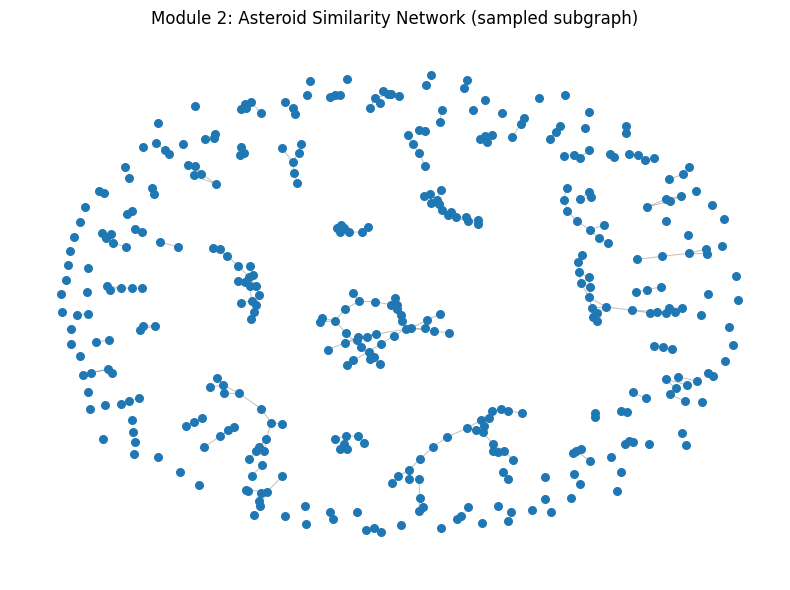

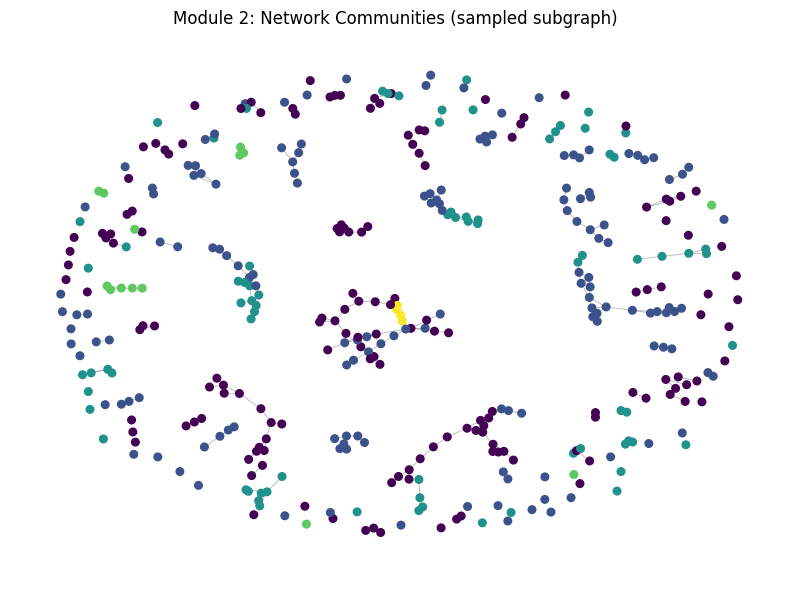

In [ ]:
# Network visualizations (sample for readability)

# Visualize a small induced subgraph from the largest CC
plot_nodes = list(H.nodes())
if len(plot_nodes) > PLOT_NODES:
    plot_nodes = rng.choice(plot_nodes, size=PLOT_NODES, replace=False).tolist()

S = H.subgraph(plot_nodes).copy()

pos = nx.spring_layout(S, seed=SEED)

plt.figure(figsize=(8, 6))
nx.draw_networkx_edges(S, pos, alpha=0.25, width=0.7)
nx.draw_networkx_nodes(S, pos, node_size=30)
plt.title("Module 2: Asteroid Similarity Network (sampled subgraph)")
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "network_sample.png"), dpi=200)
plt.show()


# Community-colored plot (if communities exist)
plt.figure(figsize=(8, 6))
node_colors = [node_to_comm.get(n, -1) for n in S.nodes()]
nx.draw_networkx_edges(S, pos, alpha=0.25, width=0.7)
nx.draw_networkx_nodes(S, pos, node_size=30, node_color=node_colors)
plt.title("Module 2: Network Communities (sampled subgraph)")
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "network_communities_sample.png"), dpi=200)
plt.show()


# If clusters exist, plot cluster-colored too
if "cluster" in net_df.columns:
    plt.figure(figsize=(8, 6))
    node_to_cluster = {str(net_df.loc[i, node_id_col]): int(net_df.loc[i, "cluster"]) for i in range(len(net_df))}
    cluster_colors = [node_to_cluster.get(n, -1) for n in S.nodes()]
    nx.draw_networkx_edges(S, pos, alpha=0.25, width=0.7)
    nx.draw_networkx_nodes(S, pos, node_size=30, node_color=cluster_colors)
    plt.title("Module 2: Module 4 Cluster Labels on Network (sampled subgraph)")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, "network_clusters_sample.png"), dpi=200)
    plt.show()



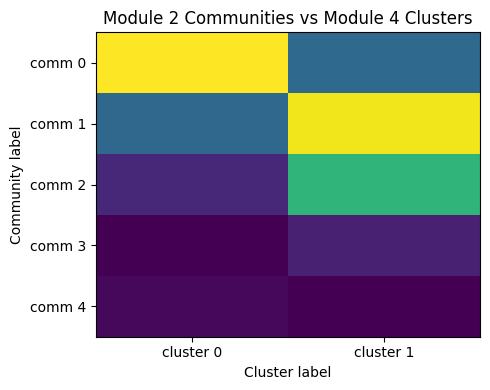

In [ ]:
comparison = pd.crosstab(metrics_df["community"], metrics_df["cluster"])

plt.figure(figsize=(5,4))
plt.imshow(comparison.values, aspect="auto")
plt.xticks([0,1], ["cluster 0", "cluster 1"])
plt.yticks(range(comparison.shape[0]), [f"comm {i}" for i in comparison.index])
plt.title("Module 2 Communities vs Module 4 Clusters")
plt.xlabel("Cluster label")
plt.ylabel("Community label")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "community_vs_cluster_heatmap.png"), dpi=200)
plt.show()


In [ ]:
# Save final node label table for later use

labels_out = metrics_df[["node", "community"]].copy()
if "cluster" in metrics_df.columns:
    labels_out["cluster"] = metrics_df["cluster"]

labels_out.to_csv(os.path.join(ARTIFACT_DIR, "node_labels_module2.csv"), index=False)

print("Saved:", os.path.join(ARTIFACT_DIR, "node_labels_module2.csv"))
print("Module 2 complete.")

Saved: ./asteroid_m2_artifacts/node_labels_module2.csv
Module 2 complete.
